In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy import units as u
from astropy.constants import G, c

import utils as ut

utils_fold = "C:/Users/Pere/Documents/code/utils/"
sys.path.append(utils_fold)
import mutils as mut
from mutils.plot_utils import Figure
from mutils.plot_utils import Figure3D
importlib.reload(mut)

<module 'mutils' from 'C:\\Users/Pere/Documents/code/utils\\mutils\\__init__.py'>

In [3]:
N_ = 33700
R = 150
fact = 6 / np.pi
N_cube = int(N_ * fact)
N_ax = int(N_cube ** (1/3))

x_cube = np.linspace(-R, R, N_ax)
y_cube = np.linspace(-R, R, N_ax)
z_cube = np.linspace(-R, R, N_ax)

X, Y, Z = np.meshgrid(x_cube, y_cube, z_cube, indexing='ij')
R_arr = np.sqrt(X**2 + Y**2 + Z**2)
idxs = R_arr < R

X_pos, Y_pos, Z_pos = X[idxs], Y[idxs], Z[idxs]

positions = np.vstack([X_pos.ravel(), Y_pos.ravel(), Z_pos.ravel()]).T

N = len(positions)
print(N)

resolution=100
ranges = [(-R, R), (-R, R), (-R, R)]
hist, edges = np.histogramdd(positions, bins=resolution, range=ranges)

30976


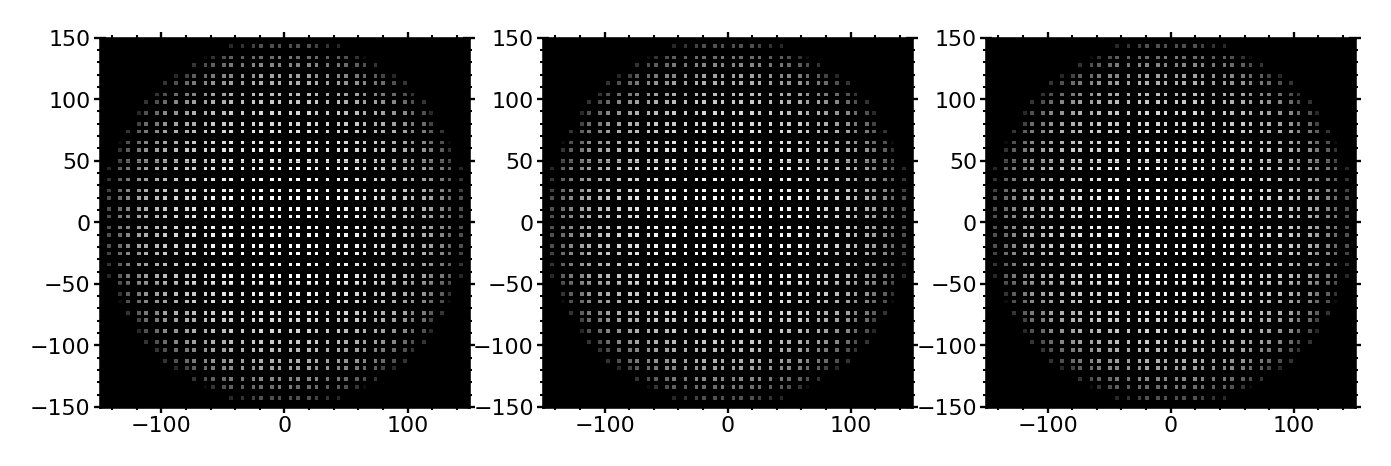

In [4]:
Fig = Figure(subplots=(1,3), ratio=3, sw=0.2, theme='default')
axs = Fig.axes

cmap = 'binary_r'

density = hist / np.nansum(hist)
x_edges, y_edges, z_edges = edges

xy_projection = np.sum(density, axis=2)
axs[0][0].imshow(xy_projection.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap=cmap)

xz_projection = np.sum(density, axis=1)
axs[0][1].imshow(xz_projection.T, extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]], origin='lower', cmap=cmap)

yz_projection = np.sum(density, axis=0)
axs[0][2].imshow(yz_projection.T, extent=[y_edges[0], y_edges[-1], z_edges[0], z_edges[-1]], origin='lower', cmap=cmap)

C:\Users\Pere\AppData\Local\Temp\ipykernel_25316\1521809633.py:8: RuntimeWarning: invalid value encountered in divide
  hist_r = hist_r / vol_element


<BarContainer object of 100 artists>

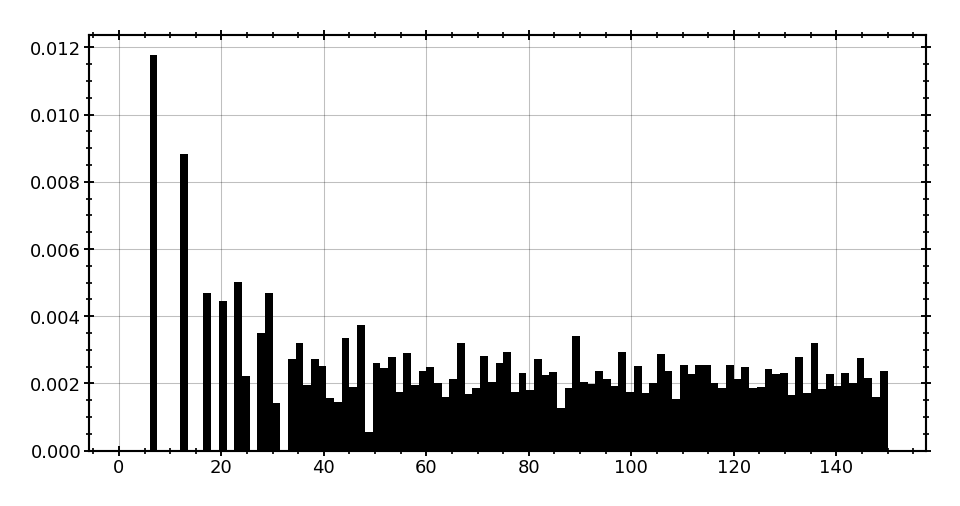

In [5]:
r = np.linalg.norm(positions, axis=1)
hist_r, bin_edges = np.histogram(r, bins=100, range=(0, R), density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = (bin_edges[1] - bin_edges[0])


vol_element = 4 * np.pi * bin_edges[:-1]**2 * bin_width
hist_r = hist_r / vol_element

Fig = Figure(theme='default')
ax = Fig.axes_flat[0]

ax.bar(bin_centers, hist_r, label='histogram', align='center', width=bin_width*1, 
       color='k', edgecolor='k', lw=0)

Compute velocities

In [10]:
Omega_m = 0.3
Omega_L = 0.7
H_0 = 70 * u.km / u.s / u.Mpc
def H(z):
    return H_0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_L)

z = 9

if z == 0:
    velocities = np.zeros_like(positions) * u.km/u.s
else:
    H_val = H(z)
    velocities = (H_val * positions*u.kpc).to(u.km/u.s)

Free fall time is
$$ \tau_{\text{ff}} = \sqrt{\frac{3 \pi}{32 G \rho}} $$

In [11]:
M_total = 1e12 * u.Msun
M_particle = M_total / N

# Convert mass to gadget units
M_total_g4 = M_total.to(u.g) / ut.M_gadget
M_particle_g4 = M_particle.to(u.g) / ut.M_gadget

# Compute the free fall time
R_g4 = (R * u.kpc).to(u.cm) / ut.L_gadget
V_g4 = 4*np.pi * (R_g4**3).value / 3
RHO_g4 = M_total_g4 / V_g4

tau_ff_g4 = ((3*np.pi)/(32*ut.G_gadget*RHO_g4))**(1/2)  # in gadget units

# Interparticle distance
d_g4 = (V_g4 / N)**(1/3)
epsilon_g4 = d_g4 / 30  # softening length

# Positions and velocities to gadget units
positions_g4 = (positions * u.kpc).to(u.cm) / ut.L_gadget
velocities_g4 = velocities.to(u.cm/u.s) / ut.v_gadget

positions_g4 = positions_g4.value
velocities_g4 = velocities_g4.value

print(f'tau_ff = {tau_ff_g4:.4f}')
print(f'end_time = {3*tau_ff_g4:.4f}')
print(f'd = {d_g4:.2e}')
print(f'epsilon = {epsilon_g4:.2e}')

tau_ff = 0.9840
end_time = 2.9519
d = 7.70e+00
epsilon = 2.57e-01


In [12]:
particle_ids = np.arange(N, dtype=np.int32) 

grid_type = 'regular'
simulation_name = 'collapsing_sphere'
savefold = f'../results/{simulation_name}/'
if not os.path.exists(savefold):
    os.makedirs(savefold)
savepath = savefold + f'IC_grid_{grid_type}_z_{z}_N_{N}.hdf5'

with h5py.File(savepath, 'w') as f:
    # Header
    header_grp = f.create_group("Header")
    header_grp.attrs['NumPart_ThisFile'] = np.array([0, N], dtype=np.int32)
    header_grp.attrs['NumPart_Total'] = np.array([0, N], dtype=np.int64)
    header_grp.attrs['MassTable'] = np.array([0, M_particle_g4], dtype=np.float32)
    header_grp.attrs['NumFilesPerSnapshot'] = np.array([1], dtype=np.int32)
    header_grp.attrs['Time'] = np.array([0], dtype=np.int32)
    header_grp.attrs['Redshift'] = np.array([z], dtype=np.int32)
    header_grp.attrs['BoxSize'] = np.array([160], dtype=np.int32)

    part_type_grp = f.create_group("PartType0")
    part_type_grp.create_dataset("Coordinates", data=positions_g4)
    part_type_grp.create_dataset("Velocities", data=velocities_g4)
    part_type_grp.create_dataset("ParticleIDs", data=particle_ids)

    part_type_grp = f.create_group("PartType1")
    part_type_grp.create_dataset("Coordinates", data=positions_g4)
    part_type_grp.create_dataset("Velocities", data=velocities_g4)
    part_type_grp.create_dataset("ParticleIDs", data=particle_ids)

In [9]:
M_Gadget = 1.989e43 * u.g
L_gadget = 3.085678e21 * u.cm
v_Gadget = 1e5 * u.cm / u.s
T_Gadget = L_gadget / v_Gadget

G_gu = G.to(u.kpc**3 / (u.Msun * u.yr**2))
c_gu = c.to(u.kpc / u.yr)

R_u = R * u.kpc
V = 4 * np.pi * R_u**3 / 3
# interparticle distance
d = (V / N)**(1/3)

total_mass = 1e12 * u.Msun
particle_mass = total_mass / N

rho = total_mass / V

tau_ff = ((3*np.pi)/(32*G_gu*rho))**(1/2)
# tau_ff

<Quantity 9.62072501e+08 yr>

In [58]:
total_mass = 1e12 * u.Msun
particle_mass = total_mass / N

V = 4 * np.pi * R**3 / 3
rho = total_mass / V

tau_ff = ((3*np.pi)/(32*G_gu*rho))**(1/2)

NameError: name 'G_gu' is not defined

<Quantity 1.00029678e+10 solMass>